In [12]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import glob,pickle,os,copy,sys,random,time
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
#goal reach distance is 8, effective load is 1, obstacle collision distance is 0.75
def get_ground_truth(gd,gd_next):
    traj=[gd[0,:2]]
    for i in range(gd.shape[0]-1):
        if (gd_next[i,:]==gd[i+1,:]).all():
            traj.append(gd[i+1,:2])
        else:
            traj.append(gd_next[i,:2])
            traj.append(gd[i+1,:2])
    traj.append(gd_next[-1,:2])
    return np.array(traj)
def gen_init_state(mu,sigma,run_idx):
    np.random.seed(run_idx)
    if run_idx==0:
        init=np.array([0.03238881511894898396,118.18717713766936583397,16.00000000000000000000,16.00000000000000000000])
        init[-2:]=np.array([16,16])
        return init
    elif run_idx==1:
        init=np.array([0.03661012901440022227,118.24889091229067616950,16.00000000000000000000,16.00000000000000000000])
        init[-2:]=np.array([16,16])
        return init
    else:
        #np.random.normal(mu,sigma,size=1)
        factor=np.random.randn()
        #init=np.random.normal(mu,sigma,size=None)
        init=np.random.uniform(0.015,0.045,4)
        init[2]=np.random.uniform(118.11,118.31)
        #init=np.array([0.034,118.21,16.00000000000000000000,16.00000000000000000000])+factor*np.array([0.01,0.15,0,0])
        init[-2:]=np.array([16,16])
        return init
def in_hull(p,H1,H2):
    if H1.find_simplex(p)>=0 and H2.find_simplex(p)<0:
        return True
    else:
        return False
loccc='Desktop'
loccc='Downloads/t42_hand'
model_path='/Users/zsbjltwjj/'+loccc+'/beliefspaceplanning/sim_nn_node/models/sim_cont_trajT_bs512_model512_BS64_loadT.pkl'
norm_path='/Users/zsbjltwjj/'+loccc+'/beliefspaceplanning/sim_nn_node/models/normalization_arr_sim_cont_trajT_bs512_model512_BS64_loadT_py2'
data_path='/Users/zsbjltwjj/Desktop/robotic_hand_simulator/sim_data_cont_v0_d4_m1_episodes.obj'
#goal_path='/Users/zsbjltwjj/Desktop/zs_sim_robot/set/goals.png'
goal_path='/Users/zsbjltwjj/Downloads/t42_hand/beliefspaceplanning/rollout_node/set/goals.png'
#set_path='/Users/zsbjltwjj/Desktop/zs_sim_robot/set/set_test/'
#obs_set_path='/Users/zsbjltwjj/Desktop/zs_sim_robot/set/obs_set_test/'
obs_set_path='/Users/zsbjltwjj/Downloads/t42_hand/beliefspaceplanning/rollout_node/set/set20c_first/'
set_mode='astar'

#if not os.path.exists(set_path):
#    os.makedirs(set_path)
if not os.path.exists(obs_set_path):
    os.makedirs(obs_set_path)
with open(data_path, 'rb') as filehandler:
    memory = pickle.load(filehandler,encoding='latin')
with open(model_path, 'rb') as pickle_file:
    model = torch.load(pickle_file, map_location='cpu')
with open(norm_path, 'rb') as pickle_file:
    x_norm_arr, y_norm_arr = pickle.load(pickle_file)
    x_mean_arr, x_std_arr = x_norm_arr[0], x_norm_arr[1]
    y_mean_arr, y_std_arr = y_norm_arr[0], y_norm_arr[1]
init_st=np.empty((0,4))
st_all=np.empty((0,2))
for idx in range(len(memory)):
    state=memory[idx][:1,:4]
    state_all=memory[idx][:,:2]
    init_st=np.concatenate((init_st,state),axis=0)
    st_all=np.concatenate((st_all,state_all),axis=0)
mu=np.mean(init_st,axis=0)
sigma=np.std(init_st,axis=0)
print(mu,sigma)

[  0.17872376 118.00470864  16.00459657  15.99866121] [1.37836163 3.13213371 0.11737433 0.1122273 ]


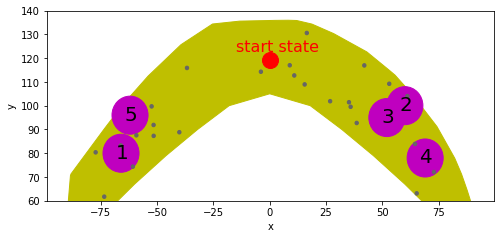

In [2]:
Goal = np.array([[-66, 80],
     [-41, 100], 
     [-62, 96], 
     [-49, 86], 
     [-55, 92],
     [59, 78],
     [31, 102],
     [60, 100],
     [52, 95],
     [-78, 67],
     [31, 125],
     [-26, 125],
     [0, 107],
     [3, 130],
     [-48, 114],
     [69, 78],
     ])
with open('/Users/zsbjltwjj/'+loccc+'/beliefspaceplanning/rollout_node/set/obs_19.pkl', 'rb') as f: 
    Obs = pickle.load(f,encoding='latin')

fig, ax = plt.subplots(figsize=(8,3.5))
#hull = ConvexHull(st_all)
#H1 = []
#for simplex in hull.vertices:
#    H1.append(st_all[simplex, :])
H1=np.array([[ 88.67572021,  44.43453217],
       [ 89.80430603,  49.65908432],
       [ 90.23077393,  52.36616516],
       [ 90.37576294,  55.98774719],
       [ 89.2946167 ,  59.5026474 ],
       [ 87.69602966,  64.31713104],
       [ 85.16108704,  71.19532013],
       [ 82.13684845,  77.89694977],
       [ 74.24691772,  91.19889069],
       [ 68.09080505,  98.77561188],
       [ 61.46546173, 106.65620422],
       [ 55.63877487, 112.83303833],
       [ 53.02430725, 114.92677307],
       [ 43.14427567, 122.59031677],
       [ 43.12343216, 122.6015625 ],
       [ 28.351017  , 130.32281494],
       [ 18.74747467, 134.30844116],
       [ 11.96526051, 135.81428528],
       [  8.20428085, 135.91555786],
       [  2.36519504, 135.85865784],
       [-13.29637909, 135.5484314 ],
       [-25.39010048, 134.3369751 ],
       [-39.37775421, 125.64316559],
       [-53.93115997, 112.47859192],
       [-65.12301636, 100.51941681],
       [-73.16171265,  90.56554413],
       [-88.19309998,  71.29073334],
       [-88.44422913,  70.54364777],
       [-89.6594696 ,  56.80038452],
       [-89.75466156,  55.28162766],
       [-89.63751221,  50.12192154],
       [-89.49487305,  48.43606567],
       [-89.34468079,  46.8845253 ],
       [-89.0162735 ,  46.1090126 ],
       [-88.13287354,  44.4129982 ],
       [-87.78145599,  43.91517639]])
H2 = np.array([[-87,41],[-83,46],[-76,52],[-60,67],[-46,79],[-32,90],[-18,100],[0,105],[18,100],[32,90],[46,79],[60,67],[76,52],[83,46],[87,41]])
H1D=Delaunay(H1)
H2D=Delaunay(H2)
H = np.concatenate((np.array(H1)[:,:], H2), axis=0)
pgon = plt.Polygon(H, color='y', alpha=1, zorder=0)
ax.add_patch(pgon)

inx = [0, 7, 8, 15, 2]

j = 1
for i in inx:
    ctr = Goal[i]
    goal_plan = plt.Circle((ctr[0], ctr[1]), 8., color='m')
    ax.add_artist(goal_plan)
    plt.text(ctr[0]-2.5, ctr[1]-2, str(j), fontsize=20)
    j += 1
for os in Obs:
    if in_hull(np.array(os[:2]),H1D,H2D):
        obs = plt.Circle(os[:2], os[2], color=[0.4,0.4,0.4])#, zorder=10)
        ax.add_artist(obs)
    
plt.plot(0, 119, 'ok', markersize=16, color ='r')
plt.text(-15, 123, 'start state', fontsize=16, color ='r')
plt.ylim([60, 140])
plt.xlabel('x')
plt.ylabel('y')
plt.savefig(goal_path, dpi=200)

In [3]:
def normalize(data,x_std_arr,x_mean_arr):
    return (data - x_mean_arr[:data.shape[-1]]) / x_std_arr[:data.shape[-1]]
def denormalize(data,y_std_arr,y_mean_arr):
    return data * y_std_arr[:data.shape[-1]] + y_mean_arr[:data.shape[-1]]
def predict(state,ac,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr):
    sa=np.concatenate([state,ac])
    inpt = normalize(sa,x_std_arr,x_mean_arr)
    inpt = torch.tensor(inpt, dtype=torch.float)
    state_delta = model(inpt)    
    state_delta = state_delta.detach().numpy()
    state_delta = denormalize(state_delta,y_std_arr,y_mean_arr)
    next_state= sa[:4] + state_delta
    return next_state

class node(object):
    def __init__(self,state):
        self.state=state
        self.loc=state[:2]
        self.load=state[2:]
        self.prev=None
        self.g=0
        self.ng=0
        self.step=0
        self.action=np.array([0,0])
    def add_prev(self,prev_node,action):
        self.prev=prev_node
        self.g=calc_g(prev_node,self)
        self.ng=0
        self.step=calc_step(prev_node,self)
        self.action=action
    def calc_f(self,h):
        #self.f=self.g+h
        self.f=self.ng+h
        #self.f=self.step+h
def isvalid(child,H1D,H2D,Obs,obs_dist):
    if not in_hull(child.loc,H1D,H2D):
        return False
    elif not ((child.load>=1).all() and (child.load<=120).all()): 
        return False
    else:
        if (np.linalg.norm(child.loc-Obs[:,:2],axis=1)>obs_dist).all():
            return True
        else:
            return False
def priority_sort(f_fringe):
    index=np.random.choice(np.argwhere(f_fringe==np.min(f_fringe)).reshape(-1),1)[0]
    #index=list(np.argwhere(f_fringe==np.min(f_fringe)))[-1][0]
    return index

def dist(start_loc,end_loc):
    return np.linalg.norm(end_loc-start_loc)
def calc_g(parent,child):
    return parent.g+dist(parent.loc,child.loc)
def calc_step(parent,child):
    return parent.step+1
def calc_h(child,goal_loc):
    return dist(child.loc,goal_loc)
    
def Astar_discrete_onestep_stomodel(initial_state,goal_loc,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,H1D,H2D,Obs,obs_dist):
    actions=[np.array([-1,1]),np.array([1,-1]),np.array([1,1]),np.array([-1,-1]),np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0])]
    
    initial=node(initial_state)
    fringe=[initial]
    initial.calc_f(dist(initial.loc,goal_loc))
    state_fringe=[initial.state]
    f_fringe=[initial.f]
    state_closed_set=[]
    
    max_size_fringe=1
    num_expanded_nodes=0
    tstart=time.time()
    while len(fringe)!=0:
        if time.time()-tstart>=3600:
            break
        index=priority_sort(f_fringe)
        
        
        state_fringe.pop(index)
        cur=fringe.pop(index)
        #print(cur.f)
        #print(cur.action)
        #print(cur.f-cur.g)
        #print(cur.f-cur.ng)
        #print(cur.f-cur.step)
        f_fringe.pop(index)

        if state_closed_set==[] or not np.any(np.all(np.isin(np.array(state_closed_set),cur.state,True),axis=1)):
            if dist(cur.loc,goal_loc)<=5.5:
                print(cur.g)
                cur_path=copy.copy(cur)
                path=[cur_path.state]
                action_path=[cur_path.action]
                while cur_path.prev != None:
                    path.insert(0,cur_path.prev.state)
                    action_path.insert(0,cur_path.prev.action)
                    cur_path=cur_path.prev
                action_path.pop(0)
                total_time=time.time()-tstart
                return "success", np.array(path), np.array(action_path),len(action_path), num_expanded_nodes, max_size_fringe, total_time
            else:#start expanding
                num_expanded_nodes+=1
                for i in actions:
                    child_state=predict(cur.state,i,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr)
                    child=node(child_state)
                    if isvalid(child,H1D,H2D,Obs,obs_dist):
                        if state_closed_set==[] or not np.any(np.all(np.isin(np.array(state_closed_set),child.state,True),axis=1)):
                            if state_fringe==[] or not np.any(np.all(np.isin(np.array(state_fringe),child.state,True),axis=1)):
                                fringe.append(child)
                                child.add_prev(cur,i)
                                child.calc_f(calc_h(child, goal_loc))
                                state_fringe.append(child.state)
                                f_fringe.append(child.f)
                if len(fringe)>max_size_fringe:
                    max_size_fringe=len(fringe)
            state_closed_set.append(cur.state)
    total_time=time.time()-tstart
    return "failure", None, None, None, num_expanded_nodes, max_size_fringe, total_time

def plot_planned_traj(set_path,set_mode,initial_state,run_idx,goal_idx,plan_path,goal_loc,H1,H2,Obs,obs_dist):
    fig, ax = plt.subplots(figsize=(8,3.5))
    H = np.concatenate((np.array(H1)[:,:], H2), axis=0)
    pgon = plt.Polygon(H, color='y', alpha=1, zorder=0)
    ax.add_patch(pgon)
    goal_plan = plt.Circle((goal_loc[0], goal_loc[1]), 8., color='m')
    ax.add_artist(goal_plan)
    plt.text(goal_loc[0]-3.5, goal_loc[1]-2.5, str(goal_idx), fontsize=20)
    H1D=Delaunay(H1)
    H2D=Delaunay(H2)
    for os in Obs:
        if in_hull(np.array(os[:2]),H1D,H2D):
            if np.linalg.norm(goal_loc-os[:2])>8+obs_dist:
                obs = plt.Circle(os[:2], obs_dist, color=[0.4,0.4,0.4])#, zorder=10)
                ax.add_artist(obs)
    plt.plot(initial_state[0], initial_state[1], 'ok', markersize=16, color ='r')
    plt.text(-15, 123, 'start state', fontsize=16, color ='r')
    if plan_path is not None:
        plt.plot(plan_path[:,0],plan_path[:,1],'-k')
    plt.ylim([60, 140])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig(set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_obs'+str(obs_dist)+'.png', dpi=200)


In [ ]:
obs_dist=0
run_idx=0
goal_idx=1
initial_state=gen_init_state(mu,sigma,run_idx)
goal_loc=Goal[goal_idx]
goal_loc=np.array([25,110])
status, plan_path, plan_action_path,len_action_path, num_expanded_nodes, max_size_fringe, total_time\
=Astar_discrete_onestep_stomodel(initial_state,goal_loc,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,H1D,H2D,Obs,obs_dist)
print(len_action_path)
np.savetxt(obs_set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_obs'+str(obs_dist)+'_traj.txt',\
           plan_path, fmt='%.20f', delimiter=',')
np.savetxt(obs_set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_obs'+str(obs_dist)+'_plan.txt',\
           plan_action_path, fmt='%.20f', delimiter=',')
plot_planned_traj(set_path,set_mode,initial_state,run_idx,goal_idx,plan_path,goal_loc,H1,H2,Obs,obs_dist)

In [ ]:
obs_dist=0
for goal_idx in [0,7,8,15,2]:
    run_idx=0
    initial_state=gen_init_state(mu,sigma,run_idx)
    goal_loc=Goal[goal_idx]
    #goal_loc=np.array([0,108])
    #acs=[np.array([-1,1]),np.array([1,-1]),np.array([1,1]),np.array([-1,-1]),np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0])]
    status, plan_path, plan_action_path,len_action_path, num_expanded_nodes, max_size_fringe, total_time\
    =Astar_discrete_onestep_stomodel(initial_state,goal_loc,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,H1D,H2D,Obs,obs_dist)
    print(len_action_path)
    np.savetxt(obs_set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_obs'+str(obs_dist)+'_traj.txt',\
               plan_path, fmt='%.20f', delimiter=',')
    np.savetxt(obs_set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_obs'+str(obs_dist)+'_plan.txt',\
               plan_action_path, fmt='%.20f', delimiter=',')
    plot_planned_traj(set_path,set_mode,initial_state,run_idx,goal_idx,plan_path,goal_loc,H1,H2,Obs,obs_dist)

In [ ]:
obs_dist=2
#for goal_idx in [0,7,8,15,2]:
for goal_idx in [8]:
    run_idx=0
    initial_state=gen_init_state(mu,sigma,run_idx)
    goal_loc=Goal[goal_idx]
    status, plan_path, plan_action_path,len_action_path, num_expanded_nodes, max_size_fringe, total_time\
    =Astar_discrete_onestep_stomodel(initial_state,goal_loc,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,H1D,H2D,Obs,obs_dist)
    print(len_action_path)
    if len_action_path is not None:
        np.savetxt(obs_set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_obs'+str(obs_dist)+'_traj.txt',\
                   plan_path, fmt='%.20f', delimiter=',')
        np.savetxt(obs_set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_obs'+str(obs_dist)+'_plan.txt',\
                   plan_action_path, fmt='%.20f', delimiter=',')
    plot_planned_traj(obs_set_path,set_mode,initial_state,run_idx,goal_idx,plan_path,goal_loc,H1,H2,Obs,obs_dist)

In [4]:
def mstep_predict(num_steps,state,ac,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr):
    next_state_arr=np.empty((0,4))
    for i in range(num_steps):
        sa=np.concatenate([state,ac])
        inpt = normalize(sa,x_std_arr,x_mean_arr)
        inpt = torch.tensor(inpt, dtype=torch.float)
        state_delta = model(inpt)    
        state_delta = state_delta.detach().numpy()
        state_delta = denormalize(state_delta,y_std_arr,y_mean_arr)
        next_state= sa[:4] + state_delta
        next_state_arr=np.concatenate((next_state_arr,next_state.reshape(1,4)),axis=0)
        state=next_state
    return next_state, next_state_arr

class mnode(object):
    def __init__(self,state,num_steps,state_h):
        self.state=state
        self.loc=state[:2]
        self.load=state[2:]
        self.state_h=state_h
        self.prev=None
        self.g=0
        self.ng=0
        self.step=0
        self.action=np.repeat(np.array([0,0]).reshape(1,2),num_steps,axis=0)
    def add_prev(self,prev_node,action):
        self.prev=prev_node
        self.g=calc_g(prev_node,self)
        self.ng=0
        self.step=calc_step(prev_node,self)
        self.action=np.repeat(action.reshape(1,2),num_steps,axis=0)
    def calc_f(self,h):
        self.f=self.g+h
        #self.f=self.ng+h
        #self.f=self.step+h
def mstep_isvalid(child,H1D,H2D,Obs,obs_dist):
    if not mstep_in_hull(child.state_h[:,:2],H1D,H2D):
        return False
    elif not ((child.state_h[:,2:]>=1).all() and (child.state_h[:,2:]<=120).all()): 
        return False
    else:
        for i in child.state_h[:,:2]:
            if not (np.linalg.norm(i-Obs[:,:2],axis=1)>obs_dist*1.2).all():
                return False
        return True
def mstep_in_hull(p,H1,H2):
    if (H1.find_simplex(p)>=0).all() and (H2.find_simplex(p)<0).all():
        return True
    else:
        return False
    
def Astar_discrete_mstep_stomodel(num_steps,initial_state,goal_loc,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,H1D,H2D,Obs,obs_dist):
    actions=[np.array([-1,1]),np.array([1,-1]),np.array([1,1]),np.array([-1,-1]),np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0])]
    
    initial=mnode(initial_state,num_steps,np.repeat(state.reshape(1,4),num_steps,axis=0))
    fringe=[initial]
    initial.calc_f(dist(initial.loc,goal_loc))
    state_fringe=[initial.state]
    f_fringe=[initial.f]
    state_closed_set=[]
    
    max_size_fringe=1
    num_expanded_nodes=0
    tstart=time.time()
    print_times=0
    while len(fringe)!=0:
        index=priority_sort(f_fringe)
        state_fringe.pop(index)
        f_fringe.pop(index)
        cur=fringe.pop(index)
        
        tm=time.time()-tstart
        if tm>=360000:
            break
        elif tm>=print_times*600:
            print_times+=1
            print(cur.f)
            #print(cur.action)
            #print(cur.f-cur.g)
            #print(cur.f-cur.ng)
            #print(cur.f-cur.step)
        
        if state_closed_set==[] or not np.any(np.all(np.isin(np.array(state_closed_set),cur.state,True),axis=1)):
            if (np.linalg.norm(goal_loc-cur.state_h[:,:2],axis=1)<=5.5).any():
                print(cur.f)
                idx=np.argwhere((np.linalg.norm(goal_loc-cur.state_h[:,:2],axis=1)<=8)==True)[0][0]
                cur_path=copy.copy(cur)
                path=[cur_path.state_h[:idx+1,:]]
                action_path=[cur_path.action[:idx+1,:]]
                while cur_path.prev != None:
                    path.insert(0,cur_path.prev.state_h)
                    action_path.insert(0,cur_path.prev.action)
                    cur_path=cur_path.prev
                action_path.pop(0)
                path[0]=path[0][:1,:]
                total_time=time.time()-tstart
                return "success", np.concatenate(path,axis=0), np.concatenate(action_path,axis=0),len(action_path), num_expanded_nodes, max_size_fringe, total_time
            else:#start expanding
                num_expanded_nodes+=1
                j=1
                for i in actions:
                    child_state,child_state_h=mstep_predict(num_steps,cur.state,i,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr)
                    child=mnode(child_state,num_steps,child_state_h)
                    if mstep_isvalid(child,H1D,H2D,Obs,obs_dist):
                        if state_closed_set==[] or not np.any(np.all(np.isin(np.array(state_closed_set),child.state,True),axis=1)):
                            if state_fringe==[] or not np.any(np.all(np.isin(np.array(state_fringe),child.state,True),axis=1)):
                                fringe.append(child)
                                child.add_prev(cur,i)
                                child.calc_f(calc_h(child, goal_loc))
                                state_fringe.append(child.state)
                                f_fringe.append(child.f)
                                j+=1
                if len(fringe)>max_size_fringe:
                    max_size_fringe=len(fringe)
            state_closed_set.append(cur.state)
    total_time=time.time()-tstart
    return "failure", None, None, None, num_expanded_nodes, max_size_fringe, total_time

def mplot_planned_traj(num_steps,set_mode,set_path,initial_state,run_idx,goal_idx,plan_path,goal_loc,H1,H2,Obs,obs_dist):
    fig, ax = plt.subplots(figsize=(8,3.5))
    H = np.concatenate((np.array(H1)[:,:], H2), axis=0)
    pgon = plt.Polygon(H, color='y', alpha=1, zorder=0)
    ax.add_patch(pgon)
    goal_plan = plt.Circle((goal_loc[0], goal_loc[1]), 8., color='m')
    ax.add_artist(goal_plan)
    plt.text(goal_loc[0]-3.5, goal_loc[1]-2.5, str(goal_idx), fontsize=20)
    H1D=Delaunay(H1)
    H2D=Delaunay(H2)
    for os in Obs:
        if in_hull(np.array(os[:2]),H1D,H2D):
            if np.linalg.norm(goal_loc-os[:2])>8+obs_dist:
                obs = plt.Circle(os[:2], obs_dist, color=[0.4,0.4,0.4])#, zorder=10)
                ax.add_artist(obs)
    plt.plot(initial_state[0], initial_state[1], 'ok', markersize=16, color ='r')
    plt.text(-15, 123, 'start state', fontsize=16, color ='r')
    if plan_path is not None:
        plt.plot(plan_path[:,0],plan_path[:,1],'-k')
    plt.ylim([60, 140])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig(set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_m'+str(num_steps)+'_obs'+str(obs_dist)+'.png', dpi=200)


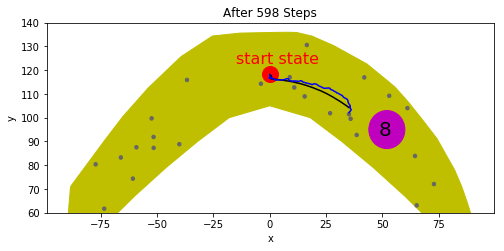

In [50]:
pklfile='/Users/zsbjltwjj/Downloads/t42_hand/beliefspaceplanning/rollout_node/set/set20c_first/astar_goal8_run0_m100_obs0.75_plan.pkl'
with open(pklfile,'rb') as f:  
    Pro = pickle.load(f,encoding='latin')
len(Pro)

obs_dist=0.75
run_idx=0
goal_idx=8
num_steps=100
initial_state=gen_init_state(mu,sigma,run_idx)
goal_loc=Goal[goal_idx]
#status, plan_path, plan_action_path,len_action_path, num_expanded_nodes, max_size_fringe, total_time\
#=Astar_discrete_mstep_stomodel(num_steps,initial_state,goal_loc,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,H1D,H2D,Obs,obs_dist)
fig, ax = plt.subplots(figsize=(8,3.5))
H = np.concatenate((np.array(H1)[:,:], H2), axis=0)
pgon = plt.Polygon(H, color='y', alpha=1, zorder=0)
ax.add_patch(pgon)
goal_plan = plt.Circle((goal_loc[0], goal_loc[1]), 8., color='m')
ax.add_artist(goal_plan)
plt.text(goal_loc[0]-3.5, goal_loc[1]-2.5, str(goal_idx), fontsize=20)
H1D=Delaunay(H1)
H2D=Delaunay(H2)
for os in Obs:
    if in_hull(np.array(os[:2]),H1D,H2D):
        if np.linalg.norm(goal_loc-os[:2])>8+obs_dist:
            obs = plt.Circle(os[:2], obs_dist, color=[0.4,0.4,0.4])#, zorder=10)
            ax.add_artist(obs)

plt.plot(initial_state[0], initial_state[1], 'ok', markersize=16, color ='r')
plt.text(-15, 123, 'start state', fontsize=16, color ='r')
num_steps=598
plt.plot(plan_path[:num_steps,0],plan_path[:num_steps,1],'-k')
plt.plot(Pro[0][:num_steps+1,0],Pro[0][:num_steps+1,1],'-b')
plt.ylim([60, 140])
plt.xlabel('x')
plt.ylabel('y')
plt.title("After "+str(num_steps)+" Steps")
plt.show()

79.821930563244
83.0986037360246
9
1741


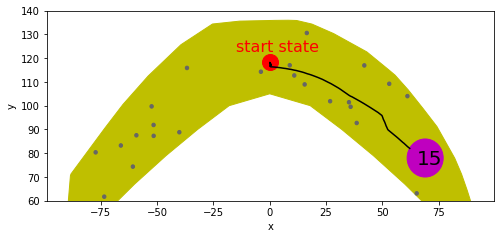

In [11]:
obs_dist=0.75
run_idx=0
goal_idx=15
num_steps=100
initial_state=gen_init_state(mu,sigma,run_idx)
goal_loc=Goal[goal_idx]
#goal_loc=np.array([25,110])
status, plan_path, plan_action_path,len_action_path, num_expanded_nodes, max_size_fringe, total_time\
=Astar_discrete_mstep_stomodel(num_steps,initial_state,goal_loc,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,H1D,H2D,Obs,obs_dist)
print(len_action_path)
print(num_expanded_nodes)
np.savetxt(obs_set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_m'+str(num_steps)+'_obs'+str(obs_dist)+'_traj.txt',\
           plan_path, fmt='%.20f', delimiter=',')
np.savetxt(obs_set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_m'+str(num_steps)+'_obs'+str(obs_dist)+'_plan.txt',\
           plan_action_path, fmt='%.20f', delimiter=',')
mplot_planned_traj(num_steps,set_mode,obs_set_path,initial_state,run_idx,goal_idx,plan_path,goal_loc,H1,H2,Obs,obs_dist)

In [ ]:
#for obs_dist in [0,0.75,1.5,3]:
for obs_dist in [0.75]:
    num_steps=100
    for goal_idx in [0,8,15]:
    #for goal_idx in [0,7,8,15,2]:
    #for goal_idx in [15]:
        run_idx=0
        initial_state=gen_init_state(mu,sigma,run_idx)
        goal_loc=Goal[goal_idx]
        #goal_loc=np.array([0,108])
        status, plan_path, plan_action_path,len_action_path, num_expanded_nodes, max_size_fringe, total_time\
        =Astar_discrete_mstep_stomodel(num_steps,initial_state,goal_loc,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,H1D,H2D,Obs,obs_dist)
        print(len_action_path)
        np.savetxt(obs_set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_m'+str(num_steps)+'_obs'+str(obs_dist)+'_traj.txt',\
                   plan_path, fmt='%.20f', delimiter=',')
        np.savetxt(obs_set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_m'+str(num_steps)+'_obs'+str(obs_dist)+'_plan.txt',\
                   plan_action_path, fmt='%.20f', delimiter=',')
        mplot_planned_traj(num_steps,set_mode,obs_set_path,initial_state,run_idx,goal_idx,plan_path,goal_loc,H1,H2,Obs,obs_dist)


76.27933449090116
79.46181056090026
79.65606434065583
79.76291357772159
79.84015364016646
79.9007873557916
79.94772841277555
79.98964976323052
80.02226395590259
80.05184829037155
80.07883697286789
80.10155648932601
80.12159109499196
80.14027593453089
80.15824249699398
80.17436647535061
80.18816873607571
80.20091408891298
80.21328203162864
80.22478146979209
80.23559654611927
80.24565045953254
80.25563424307131
80.26458045974213
80.27339254422824
80.28165476988008
80.28983303827707
80.29737468011608
80.30495909283083
80.31193879277919
80.31893569718325
80.32538779576377
80.33157199170412
80.3381850330784
80.34418955955181
80.3497388702243
80.35482748457866
80.36019243939015
80.36506022951669
80.37002929140408
80.37483713338904
80.3796521164996
80.38385844008852
80.38806792171323
80.39241931713039
80.39663275483603
80.40077986183891
80.40492694008904
80.40888693583936
80.41245519282157
80.41613967193373
80.41970637200478
80.42308274926533
80.42647318231887
80.4300621917319
80.433253094380